# Credit Card Fraud

Fraud Detection or Anomaly Detection can have some problems because of imbalanced dataset
How to solve this?
- Undersampling: 많은 데이터 세트를 적은 수준으로 감소
- Oversampling: 적은 데이터 세트를 증식, 학습을 위한 데이터 확보
    - SMOTE (Synthetic Minority Over-sampling Technique) method: find small dataset's each data's K nearest Neighbor, and make new data based on the difference of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("../creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
from sklearn.model_selection import train_test_split

# delete Time column, return copied DataFrame
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop("Time", axis=1, inplace=True)
    return df_copy

In [3]:
# after data preprocessing, split dataset
def get_train_test_dataset(df=None):
    # return DataFrame
    df_copy = get_preprocessed_df(df)

    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                        random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [4]:
print("training dataset label ratio")
print(y_train.value_counts() / y_train.shape[0] * 100)

print("test dataset label ratio")
print(y_test.value_counts() / y_test.shape[0] * 100)

training dataset label ratio
0    99.827451
1     0.172549
Name: Class, dtype: float64
test dataset label ratio
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("confusion matrix: \n", confusion)
    print("accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, ROC-AUC: {4:.4f}"
          .format(accuracy, precision, recall, f1, roc_auc))

In [6]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_prd = lr_clf.predict(X_test)
lr_prd_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_prd, lr_prd_proba)

confusion matrix: 
 [[85281    14]
 [   58    90]]
accuracy: 0.9992, precision: 0.8654, recall: 0.6081, f1: 0.7143, ROC-AUC: 0.9703


In [7]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    prd = model.predict(ftr_test)
    prd_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, prd, prd_proba)

In [8]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1,
                          boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

confusion matrix: 
 [[85290     5]
 [   36   112]]
accuracy: 0.9995, precision: 0.9573, recall: 0.7568, f1: 0.8453, ROC-AUC: 0.9790


## Change Data distribution

<AxesSubplot:xlabel='Amount', ylabel='Count'>

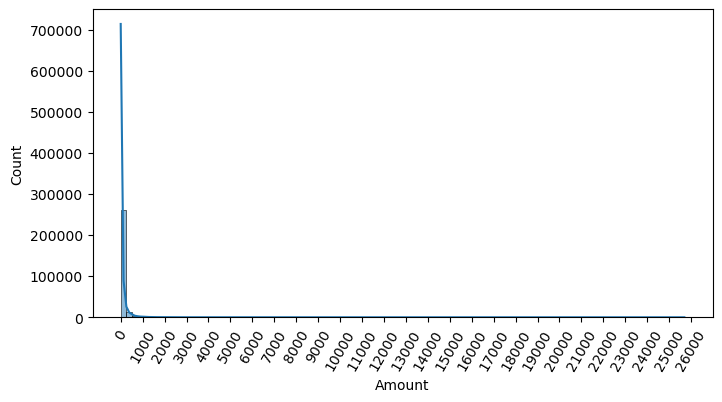

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df["Amount"], bins=100, kde=True)

데이터가 불균형함으로 정규분포화 할 필요 있음

In [20]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy["Amount"].values.reshape(-1, 1))

    # change scaled Amount to Amount_Scaled
    df_copy.insert(0, "Amount_Scaled", amount_n)

    df_copy.drop(["Time", "Amount"], axis=1, inplace=True)
    return df_copy

In [17]:
# LightGBM
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("LogisticRegression prediction performance")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("LightGBM prediction performance")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

LogisticRegression prediction performance
confusion matrix: 
 [[85281    14]
 [   58    90]]
accuracy: 0.9992, precision: 0.8654, recall: 0.6081, f1: 0.7143, ROC-AUC: 0.9702
LightGBM prediction performance
confusion matrix: 
 [[85290     5]
 [   37   111]]
accuracy: 0.9995, precision: 0.9569, recall: 0.7500, f1: 0.8409, ROC-AUC: 0.9779


In [18]:
# log scale to dataset
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy["Amount"])
    df_copy.insert(0, "Amount_Scaled", amount_n)
    df_copy.drop(["Time, Amount"], axis=1, inplace=True)
    return df_copy

In [21]:
# LightGBM
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("LogisticRegression prediction performance")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("LightGBM prediction performance")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

LogisticRegression prediction performance
confusion matrix: 
 [[85281    14]
 [   58    90]]
accuracy: 0.9992, precision: 0.8654, recall: 0.6081, f1: 0.7143, ROC-AUC: 0.9702
LightGBM prediction performance
confusion matrix: 
 [[85290     5]
 [   37   111]]
accuracy: 0.9995, precision: 0.9569, recall: 0.7500, f1: 0.8409, ROC-AUC: 0.9779
